# 第2章 最尤推定と線形モデル

## 2.1 確率モデルと最尤推定
* 最尤推定のはなし

## 2.2 確率的勾配降下法
* 対数尤度関数を最大化するかわりに、損失関数の最小化を行う
* 勾配降下法: 勾配（微分係数）を利用して繰り返し最適化していく手法
* 学習率が大きいと損失関数の減少は速いが、収束せずに振動する可能性がある
* 学習率が小さいと損失関数の減少が遅く、収束までの計算量が増える（時間がかかる）
* 確率的勾配降下（SGD）: ランダムに一部の値（ミニバッチ）のみを使用する

## 2.3.2 線形回帰モデル（from scratch）
* 線形回帰のパラメータ（回帰係数）を最尤推定によって求める
* 平均二乗誤差（MSE）の最小化問題を解く

In [11]:
%matplotlib inline
import torch
from torch.autograd import Variable as V
from torch import nn, optim
from matplotlib import pyplot as plt

seed_value = 72

In [70]:
# y = 1 + 2x1 + 3x2 という線形モデルを考える

# 真の係数
w_true = torch.Tensor([1, 2, 3])

# Xのデータの準備
# 切片を回帰係数に含めるため、Xの最初の次元に1を追加しておく
torch.manual_seed(seed_value)
X = torch.cat([torch.ones(100, 1), torch.randn(100, 2)], 1)
print(X[:5])

tensor([[ 1.0000, -0.6095,  0.0248],
        [ 1.0000, -0.6509, -1.2133],
        [ 1.0000, -0.9720,  0.5561],
        [ 1.0000, -0.8389, -2.5504],
        [ 1.0000, -0.6438,  0.9496]])


In [84]:
# 真の係数と各xとの内積を行列とベクトルの積でまとめて計算
# randnで生成した乱数を足して誤差としてる？（観測データ的な）
torch.manual_seed(seed_value)
y = torch.mv(X, w_true) + torch.randn(100) * 0.5
print(y)

# X, yをVariableに変換
X = V(X)
y = V(y)

# 勾配降下で最適化するためのパラメータのVariableを乱数で初期化して生成
torch.manual_seed(seed_value)
w = V(torch.randn(3), requires_grad = True)
print(w)

# 学習率
gamma = 0.1

tensor([-0.4494, -3.9292,  0.3990, -8.9358,  2.0753,  1.0392,  3.7973, -1.4377,
        -3.0853, -1.5062, -9.2202,  0.1761, -1.9354, -1.3786,  4.0999,  4.0928,
         5.5666,  3.9242, -1.8017, -1.7996, -3.4828,  1.3144, -7.1538,  5.7456,
        -1.1512, -3.5932,  0.8378, -1.4823,  0.3529, -0.2749, -6.9282, -0.3187,
        -0.0309,  1.4050, -0.1761,  2.9766,  3.9112,  2.3424,  2.7866,  2.2523,
         0.9887, -5.4973, -4.2799, -9.5841,  5.6943,  1.7478, -2.5283, -5.3010,
         6.1077, -0.0281,  8.4536,  2.1970, -1.0746,  2.0529, -2.6047, -1.9677,
         3.0923,  1.0054, -1.2799,  2.2632,  0.6018,  2.8166, -4.3391, -1.8121,
         3.0087, -1.5564, -5.6164,  6.5953,  3.2711, -1.3833,  1.5919, -2.2853,
         9.5498,  2.9476,  2.0338,  1.3312, -1.0840, -2.8980,  3.9825, -4.2536,
         4.4574,  0.8592, -1.2145,  0.1011, -3.9195,  5.6365, 10.1037, -1.1222,
         1.6445, -6.7296, -2.0261,  2.0939, -1.2813,  3.0510, -0.7837,  1.8710,
        -2.3043,  4.0143,  3.7297, -0.57

In [85]:
# 損失関数のログ
losses = []

# 100回イテレーションを回す
for epoc in range(100):
    # 前回のbackwardメソッドで計算された勾配の値を削除
    w.grad = None
    
    # 線形モデルでyの予測値を計算
    y_pred = torch.mv(X, w)
    # print(y_pred.shape) # 100要素のベクトル
    
    # MSE lossとwによる微分を計算
    loss = torch.mean((y - y_pred) ** 2)
    loss.backward()
    
    # 勾配を更新する
    # wをそのまま代入して更新すると異なるVariableになって計算グラフが破壊されるので、dataだけを更新する
    w.data = w.data - gamma * w.grad.data
    
    # 収束確認のためにlossを記録しておく
    losses.append(loss.item())

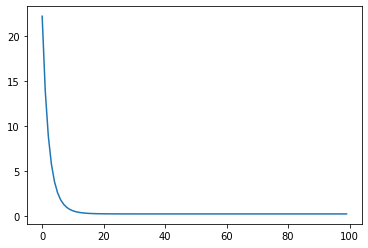

In [73]:
# 損失関数の収束を確認
plt.plot(losses)

In [74]:
# 最適化された回帰係数
print(w)

tensor([0.9240, 1.8767, 3.0200], requires_grad=True)


## 2.3.3 線形回帰モデル（nn, optimモジュールの使用）
* モデル構築、勾配計算はpytorchのモジュールで簡単にできる
* モデル構築: torch.nn()
* 最適化: torch.optim()

In [88]:
# linear層を作成
# 今回は切片項は回帰係数に含めるので、入力の次元を3とし、bias（切片）をFalseにする
net = nn.Linear(in_features=3, out_features=1, bias=False)

# SGD（確立的勾配降下法）のオプティマイザーに上で定義したネットワークのパラメータを渡して初期化
optimizer = optim.SGD(net.parameters(), lr=0.1)

# MSE lossクラス
loss_fn = nn.MSELoss()

In [89]:
# 損失関数のログ
losses = []

# 100回イテレーションを回す
for epoc in range(100):
    # 前回のbackwardメソッドで計算された勾配の値を削除
    optimizer.zero_grad()
    
    # 線形モデルでyの予測値を計算
    y_pred = net(X)
    # view_as()は値と要素数は同じでshapeが異なるTensorを返す（yと同じshapeにする）
    # print(y_pred.shape) # 100x1の行列
    # print(y_pred.view_as(y).shape) # 100要素のベクトル
    
    # MSE lossとwによる微分を計算
    #loss = loss_fn(y_pred, y) # これだとshapeが違うのでダメっぽい
    loss = loss_fn(y_pred.view_as(y), y)
    loss.backward()
    
    # 勾配を更新する
    optimizer.step()
    
    # 収束確認用にlossを記録
    losses.append(loss.item())

In [90]:
list(net.parameters())

[Parameter containing:
 tensor([[0.9240, 1.8767, 3.0200]], requires_grad=True)]

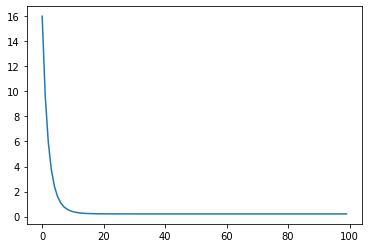

In [91]:
# 損失関数の収束を確認
plt.plot(losses)

## 2.4 ロジスティック回帰
* ロジスティック回帰: 線形結合をとったあとにシグモイド関数を通して\[0, 1\]の値に変換する
* 損失関数はクロスエントロピーを使う

In [3]:
from sklearn.datasets import load_iris
iris = load_iris()

# irisは3クラス分類だが、ここでは2クラス分類を行う
# 本来はtrainとtestに分けるべきだが今回は省略
X = iris.data[:100]
y = iris.target[:100]

# ndarrayをVariableに変換
X = V(torch.Tensor(X))
y = V(torch.Tensor(y))

In [4]:
print(X.shape)

torch.Size([100, 4])


In [15]:
# irisのデータは4次元
net = nn.Linear(4, 1)

# シグモイド関数を作用させ、2クラス分類のクロスエントロピーを計算する
loss_fn = nn.BCEWithLogitsLoss()

# SGD（少し大きめの学習率）
optimizer = optim.SGD(net.parameters(), lr=0.25)

In [16]:
# 損失関数のログ
losses = []

# 100回イテレーションを回す
for epoc in range(100):
    # 前回の勾配の値を削除
    optimizer.zero_grad()
    
    # ロジスティック回帰の予測値を計算
    y_pred = net(X)
    
    # MSE lossとwによる微分を計算
    loss = loss_fn(y_pred.view_as(y), y)
    loss.backward()
    
    # 勾配を更新する
    optimizer.step()
    
    # 収束確認用にlossを記録
    losses.append(loss.item())

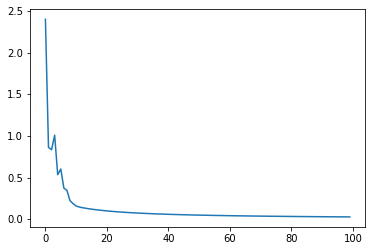

In [17]:
# 損失関数の収束を確認
plt.plot(losses)

In [28]:
# 予測は下記のように行う

# ロジスティック回帰の結果
h = net(X)

# シグモイド関数を作用させた結果はy=1の確率を表す
prob = torch.sigmoid(h)

# 確率が0.5以上のものをクラス1予想し、それ以外を0とする
# pytorchにはBoolがないのでByteTensorが使用される
y_pred = prob > 0.5

# 予測結果の確認（yはFloatTensorなのでByteTensorに変換してから比較する）
(y.byte() == y_pred.view_as(y)).sum()

tensor(100)

## 2.4.3 他クラスのロジスティック回帰

In [67]:
from sklearn.datasets import load_digits
digits = load_digits()

X = digits.data
y = digits.target
print(X.shape)
print(X[:3])

X = V(torch.Tensor(X))
# CrossEntropyLoss関数はyとしてLongTensorを受け取るので注意
y = V(torch.LongTensor(y))

# 入力は64次元、出力は10次元（クラス数）
net = nn.Linear(X.shape[1], 10)

# ソフトマックスクロスエントロピー
loss_fn = nn.CrossEntropyLoss()

# SGD
optimizer = optim.SGD(net.parameters(), lr=0.01)

(1797, 64)
[[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
  15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
   0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
   0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
 [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
   3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
  16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
   0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
 [ 0.  0.  0.  4. 15. 12.  0.  0.  0.  0.  3. 16. 15. 14.  0.  0.  0.  0.
   8. 13.  8. 16.  0.  0.  0.  0.  1.  6. 15. 11.  0.  0.  0.  1.  8. 13.
  15.  1.  0.  0.  0.  9. 16. 16.  5.  0.  0.  0.  0.  3. 13. 16. 16. 11.
   5.  0.  0.  0.  0.  3. 11. 16.  9.  0.]]


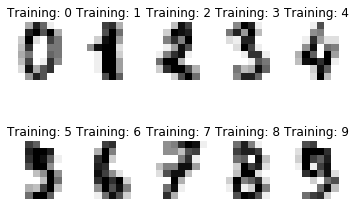

In [61]:
# 画像にして出力
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.axis('off')
    plt.title('Training: %i' % label)
plt.show()

In [68]:
# 学習
losses = []

for epoc in range(100):
    # 勾配の削除
    optimizer.zero_grad()
    
    # 予測値の計算
    # 10クラスに対する予測確率と、予測確率が最も大きいクラスのインデックスを持つ
    y_pred = net(X)
    
    # 損失の計算と微分
    # ここは10次元をそのまま突っ込めばok
    loss = loss_fn(y_pred, y)
    loss.backward()
    
    # 勾配の更新
    optimizer.step()
    
    # 損失の記録
    losses.append(loss.item())

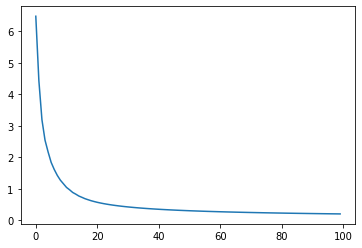

In [69]:
# 損失関数の収束を確認
plt.plot(losses)

In [81]:
# 予測
# どっちでもいいっぽいが下の方が早い（なぜかはわからん）
# _, y_pred = net(X).max(1)
_, y_pred = torch.max(net(X), 1)

# 正解率を計算する
# ByteTensorのままsumをするとoverflowするので、FloatTensorに変換してからsumをとる
(y_pred == y).float().sum() / len(y)

tensor(0.9521)